<a href="https://colab.research.google.com/github/RicardxJMG/Simple-Robot-Trading/blob/main/Robot_trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Configuración del ambiente**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import yfinance as yf
from bs4 import BeautifulSoup as bs
# from datetime import date, timedelta

# **2. Obtención de los datos**

## **2.1 Precios Historicos del Bitcoin**

Se cargarán los precios (en dólares ) históricos del Bitcoin en de los últimos 7 días en un intervalo de 5 minutos.

In [ ]:
# Obteniendo datos historicos del Bitcoin
def dataframe_bitcoin() -> pd.DataFrame():
  return yf.download('BTC-USD', period= '7d', interval='5m')

In [ ]:
df_bitcoin = dataframe_bitcoin()
df_bitcoin.head(5)

/tmp/ipython-input-2-2938597639.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  return yf.download('BTC-USD', period= '7d', interval='5m')
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
Datetime,,,,,
2025-07-10 00:00:00+00:00,111337.906250,111337.906250,111301.765625,111301.765625,0
2025-07-10 00:05:00+00:00,111329.656250,111336.882812,111321.742188,111321.742188,79646720
2025-07-10 00:10:00+00:00,111334.250000,111334.250000,111306.421875,111324.523438,0
2025-07-10 00:15:00+00:00,111315.187500,111346.734375,111302.601562,111346.734375,168644608
2025-07-10 00:20:00+00:00,111256.757812,111316.609375,111247.585938,111316.609375,15126528


Para entender mejor el contenido del dataframe:
* **Datetime:** Es el índice del dataframe, y contiene la fecha y hora del intervalo seleccionado, no puede estar duplicado.
* **Open:** Contiene el precio del Bitcoin al inicio del intervalo.
* **High:** Contiene el precio más alto del Bitcoin durante el intervalo.
* **Low:** Contiene el precio más bajo del Bitcoin durante el intervalo.
* **Close:** Contiene el precio del Bitcoin al final del intervalo.
* **Volume:** Contiene el total de transacciones hechas durante el intervalo.



## **2.2 Extrayendo precio actual y tendencia del Bitcoin.**

Para conocer el precio real y la tendencia de BitCoin, nos basaremos en los datos de la página de [CoinMarketCap](https://coinmarketcap.com/)

In [ ]:
def extraer_tendencias() -> tuple[float, str]:
  precio_actual: float = 0
  tendencia: str = ""

  url: str = 'https://coinmarketcap.com/'

  respuesta = requests.get(url)

  if respuesta.status_code == 200:
    s: bs = bs(respuesta.text, 'html.parser')
    #Obteniendo los span de la primera fila de la tabla de coinmarketcap.com
    html_row = s.find_all("tbody")[0]

    cripto_row = html_row.find("a", href="/currencies/bitcoin/").find_parent("tr").find_all("td")
    #  el tercer indice contiene el prcio actual de la criptomoneda
    #  el cuarto indice contiene la tencdencia actual

    precio_actual = float(cripto_row[3].text.replace('$', '').replace(',',''))
    tendencia_td = cripto_row[4].find("span")

    if tendencia_td.attrs['class'][0] == "icon-Caret-up":
      tendencia = 'alta'
    else:
      tendencia = 'baja'

    return (precio_actual, tendencia)
  else:
    print("Error al cargar la página de CoinMarketCap")
    return (precio_actual, tendencia)

In [ ]:
precio_actual, tendencia = extraer_tendencias()
print(f'Precio actual: {precio_actual}')
print(f'Tendencia: {tendencia}')

Precio actual: 118273.25
Tendencia: baja


# **3. Limpieza de datos**

## **3.1 Análisis antes de la limpieza de datos**

La siguiente función imprime la siguiente informacion del dataframe original: La cantidad de registros duplicados, si existen valores nulos en la columna *close* y cuenta el total de registros cuyo *Volume* no es mayor a cero, i.e, aquellos registros en que no se hizo ninguna transacción.

In [ ]:
def analisis(df: pd.DataFrame):

  indices_repetidos = df.duplicated().sum()
  valores_nulos_close = 'Si' if df.Close.isna().any().any() == True else "No"
  registros_cero = df.Volume[df.Volume <= 0].count().to_list()[0]

  print('Análisis del dataframe original:')
  print(f'\n  - El dataframe contiene {df.shape[0]} registros.')
  print(f'  - Existen {indices_repetidos} indices repetidos.')
  print(f'  - Existen valores nulos en la columna "Close": {valores_nulos_close}')
  print(f'  - Registros que tengan registros Volume de transacción menor o igual a cero: {registros_cero}')

analisis(df_bitcoin)

Análisis del dataframe original:

  - El dataframe contiene 1810 registros.
  - Existen 0 indices repetidos.
  - Existen valores nulos en la columna "Close": No
  - Registros que tengan registros Volume de transacción menor o igual a cero: 898


In [ ]:
df_bitcoin.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1810 entries, 2025-07-10 00:00:00+00:00 to 2025-07-16 06:45:00+00:00
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   (Close, BTC-USD)   1810 non-null   float64
 1   (High, BTC-USD)    1810 non-null   float64
 2   (Low, BTC-USD)     1810 non-null   float64
 3   (Open, BTC-USD)    1810 non-null   float64
 4   (Volume, BTC-USD)  1810 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 84.8 KB


Antes de la limpieza de datos, ajustemos el multiindice del dataframe

In [ ]:
def ajuste_columns(df: pd.DataFrame) -> pd.DataFrame:
  df_copy = df.copy()
  df_copy.columns = [f'{level_1}' for level_1, level_2 in df_copy.columns]
  return df_copy

In [ ]:
copy_bitcoin = ajuste_columns(df_bitcoin)
copy_bitcoin.head(3)

,Close,High,Low,Open,Volume
Datetime,,,,,
2025-07-10 00:00:00+00:00,111337.90625,111337.906250,111301.765625,111301.765625,0
2025-07-10 00:05:00+00:00,111329.65625,111336.882812,111321.742188,111321.742188,79646720
2025-07-10 00:10:00+00:00,111334.25000,111334.250000,111306.421875,111324.523438,0


In [ ]:
df_bitcoin = copy_bitcoin.copy()
del copy_bitcoin

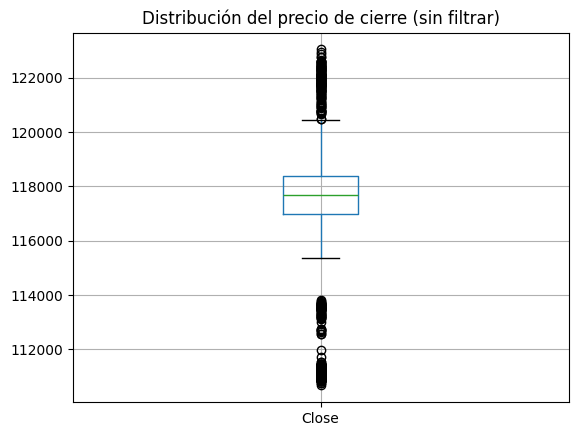

In [ ]:
df_bitcoin.boxplot("Close");
plt.title("Distribución del precio de cierre (sin filtrar)");

## **3.2 Creación de la función que limpia la base de datos**

De la copia del dataframe, se realizará la siguienete limpieza:
1. Los valores duplicados serán eliminados, encaso de existir.
2. En la columna que almacena los precios de cierre, en caso de que el valor sea nulo, este será llenado con el valor anterior que no lo es.
3. Serán elimindaos aquellos registros cuyo volume de transacción no sean mayores a cero.
4. Nos concentraremos en aquellos registros cuyos precios de cierre se encuentren entre los quartiles $Q_1,\ Q_3$.

In [ ]:
def limpieza_datos(df: pd.DataFrame) -> tuple[float, pd.DataFrame]:
  media: float = 0

  #Limpieza b[asica en caso de ser requerida
  df_limpio = df.copy()
  df_limpio.drop_duplicates(inplace=True)
  valores_nulos = df_limpio.Close.isna().any()
  if valores_nulos == True:
    df_limpio.Close.fillna(method='ffill', inplace=True)

  # Eliminado registros que tengan un Volume de transaccion igual cero
  query = df_limpio.query('Volume <= 0').index
  df_limpio.drop(query, axis = 0, inplace = True)

  Q1 = df_limpio.Close.quantile(0.25)
  Q3 = df_limpio.Close.quantile(0.75)
  # IIQ = Q3-Q1
  df_limpio = df_limpio.query(f'Close > {Q1} & Close < {Q3}')

  # Calculando la media con los datos ya filtrados.
  media = df_limpio.Close.mean()

  return (media, df_limpio)

In [ ]:
precio_medio, df_limpio = limpieza_datos(df_bitcoin)
print(f'El precio medio del Bitcoin es: {precio_medio:.2f}\n\n')
df_limpio.head(3)


El precio medio del Bitcoin es: 117769.11




,Close,High,Low,Open,Volume
Datetime,,,,,
2025-07-11 04:50:00+00:00,116914.523438,116914.523438,116855.859375,116860.289062,32563200
2025-07-11 05:05:00+00:00,117239.820312,117239.820312,116950.343750,116950.343750,850018304
2025-07-11 05:15:00+00:00,117256.468750,117321.578125,117235.273438,117235.273438,357408768


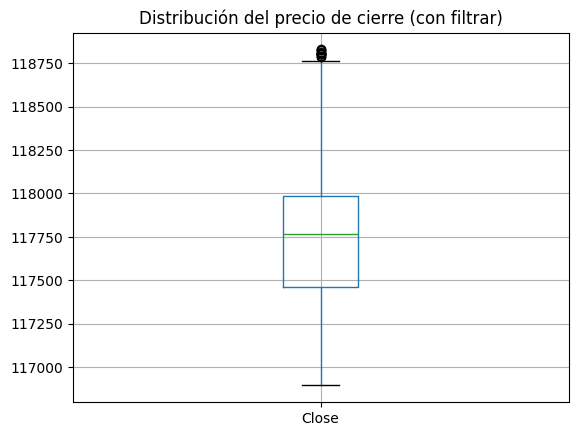

In [ ]:
df_limpio.boxplot('Close');
plt.title("Distribución del precio de cierre (con filtrar)");

# **4. Toma de decisiones**

In [ ]:
def tomar_decision(media_bitcoin: float, tendencia: str ) -> str:

  if precio_actual >= media_bitcoin and tendencia == 'baja':
    return 'Vender'
  elif precio_actual < media_bitcoin and tendencia == 'alta':
    return 'Comprar'
  else:
    return 'Esperar'

In [ ]:
decision = tomar_decision(precio_medio, tendencia)
print(f'La decisión a tomar es: {decision}')

La decisión a tomar es: Vender


# **5. Visualización**

In [ ]:
def visualizacion(df: pd.DataFrame, media: float, tendencia: str, algoritmo_decision:str) ->  None:

  df_copy = df.copy()
  # Añadiendo una nueva columna
  df_copy['Promedio'] = media

  # Configuración del gráfico
  plt.style.use("dark_background")
  plt.figure(figsize=(16,5))
  plt.title('Precio cierre del Bitcoin en los últimos 7 días')
  plt.plot(df_copy.index, df_copy.Close, linewidth = 0.85, color = '#ffffff');
  plt.plot(df_copy.index, df_copy.Promedio, color = 'orange', linestyle = '--');
  plt.legend(['Precio cierre del Bitcoin', 'Promedio'])
  plt.grid(True, lw = 0.25, ls = '--')

  color = 'green' if algoritmo_decision == 'Vender' else 'blue' if algoritmo_decision == 'Comprar' else 'red'
  plt.annotate(algoritmo_decision,
               xy=(df_copy.index[-1],df_copy.Close.iloc[-1]),
               xytext=(df_copy.index[-1], df_copy.Close.iloc[-1]-1500),
               arrowprops=dict(facecolor=color, shrink=.1, width = 3, headwidth = 8),
               horizontalalignment='center')

  plt.show()


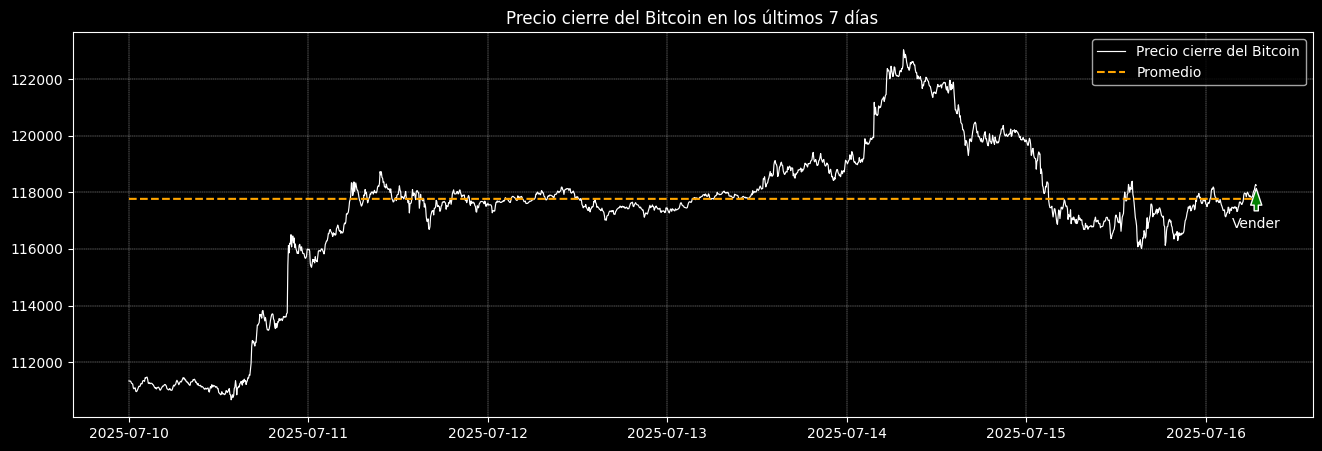

In [ ]:
visualizacion(df_bitcoin, precio_medio, tendencia, decision)

## **6. Automatización**

In [ ]:
from IPython.display import clear_output
import time
import sys

In [ ]:
def bot_trader(tiempo_actualizacion: int = 300) -> None:
  """
    tiempo_actualizacion: En segundos, representa cada cuanto tiempo se va a actualizar la información.
    Ejemplo: tiempo_actualizacion = 300 significa que se actualizará la información cada 5 minutos.
  """

  while(True):
      clear_output()
      df_bitcoin = dataframe_bitcoin()
      df_bitcoin = ajuste_columns(df_bitcoin)
      precio_actual, tendencia = extraer_tendencias()
      precio_medio, df_limpio = limpieza_datos(df_bitcoin)
      decision = tomar_decision(precio_medio, tendencia)

      print(f'\n\nPrecio actual: ${precio_actual} USD')
      print(f'Tendencia: {tendencia}')
      print(f'El precio medio del Bitcoin es: ${precio_medio:.2f} USD')
      print(f'La decisión a tomar es: {decision}\n')

      visualizacion(df_bitcoin, precio_medio, tendencia, decision)
      try:
        print('')
        for i in range(tiempo_actualizacion, 0, -1):
            sys.stdout.write(f"\rPróxima actualización en: {i} segundos")
            sys.stdout.flush()
            time.sleep(1)
        sys.stdout.write("\rActualizando ahora...\n")
        sys.stdout.flush()
      except KeyboardInterrupt:
        print("\n\n>> Ejecución detenida")
        break

/tmp/ipython-input-2-2938597639.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  return yf.download('BTC-USD', period= '7d', interval='5m')
[*********************100%***********************]  1 of 1 completed




Precio actual: $118701.75 USD
Tendencia: baja
El precio medio del Bitcoin es: $117788.60 USD
La decisión a tomar es: Vender



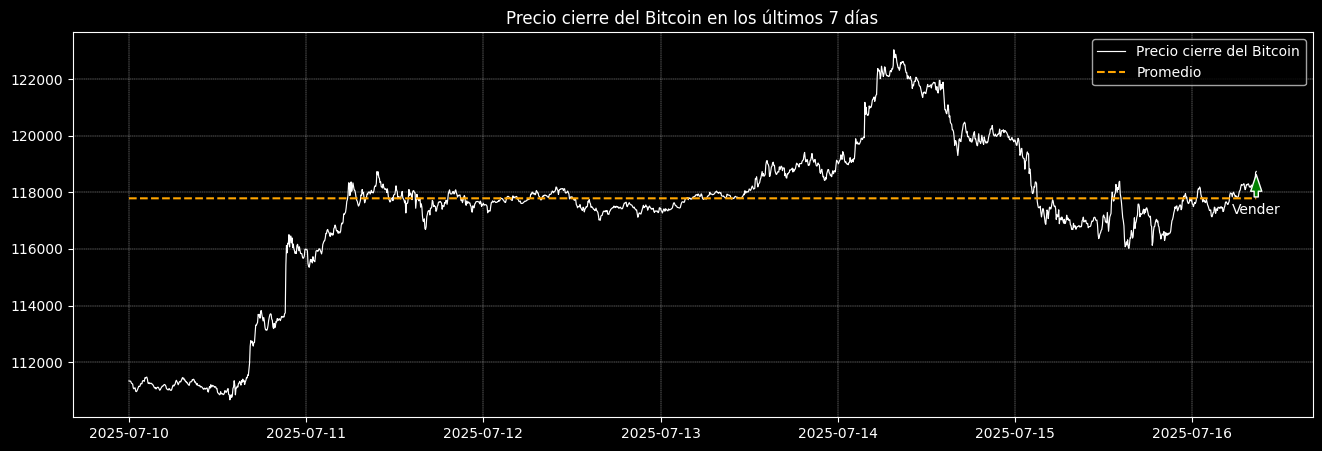


Próxima actualización en: 9 segundos

>> Ejecución detenida


In [ ]:
bot_trader()